In [106]:
import warnings
warnings.filterwarnings('ignore')

import glob
import numpy
import matplotlib.pyplot as plt
import iris
import iris.plot as iplt

In [107]:
infile = '/g/data/r87/dbi599/DRSv2/CMIP6/HadGEM3-GC31-LL/piControl/r1i1p1f1/Omon/wfo/gn/wfo-zonal-sum_Omon_HadGEM3-GC31-LL_piControl_r1i1p1f1_gn_all.nc'
cube = iris.load_cube(infile, 'water_flux_into_sea_water')

In [108]:
cube.summary(shorten=True)

'water_flux_into_sea_water / (kg)    (time: 500; latitude: 144)'

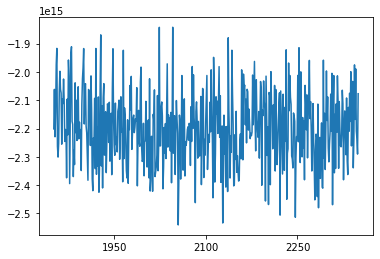

In [109]:
iplt.plot(cube[:, 50])
plt.show()

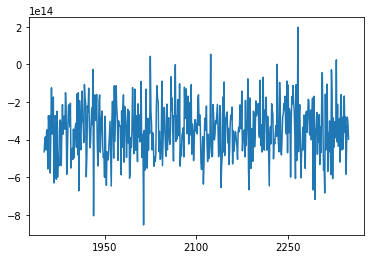

In [110]:
iplt.plot(cube[:, 100])
plt.show()

## Finding an appropriate baseline window

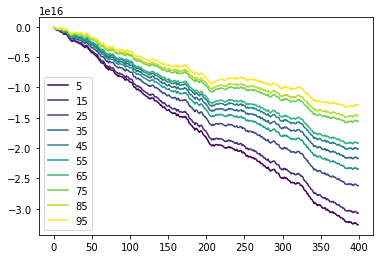

In [111]:
lat = 50
windows = [5, 15, 25, 35, 45, 55, 65, 75, 85, 95]
color=iter(plt.cm.viridis(numpy.linspace(0, 1, len(windows))))
for ref_window in windows:
    start = cube[0:ref_window, lat].data.mean()
    cumsum = numpy.cumsum(cube[100:, lat].data - start)
    c=next(color)
    plt.plot(cumsum, c=c, label=str(ref_window))

plt.legend()
plt.show()

## Plotting the drift

In [88]:
def cumulative_anomaly(data, window):
    """Calculate the cumulative anomaly"""
    
    baseline = data[0:window].mean()
    cumsum = numpy.cumsum(data - baseline)
    
    return cumsum[-1]


def align_yaxis(ax1, ax2):
    """Align zeros of the two axes, zooming them out by same ratio
    Taken from: https://stackoverflow.com/questions/10481990/matplotlib-axis-with-two-scales-shared-origin
    """
    axes = (ax1, ax2)
    extrema = [ax.get_ylim() for ax in axes]
    tops = [extr[1] / (extr[1] - extr[0]) for extr in extrema]
    # Ensure that plots (intervals) are ordered bottom to top:
    if tops[0] > tops[1]:
        axes, extrema, tops = [list(reversed(l)) for l in (axes, extrema, tops)]

    # How much would the plot overflow if we kept current zoom levels?
    tot_span = tops[1] + 1 - tops[0]

    b_new_t = extrema[0][0] + tot_span * (extrema[0][1] - extrema[0][0])
    t_new_b = extrema[1][1] - tot_span * (extrema[1][1] - extrema[1][0])
    axes[0].set_ylim(extrema[0][0], b_new_t)
    axes[1].set_ylim(t_new_b, extrema[1][1])

In [101]:
def plot_drift(drift, clim, lats, color, label):
    """Plot the drift"""
    
    fig, ax1 = plt.subplots(figsize=[8, 5])

    plt.axhline(y=0, color='black', linewidth=0.5)

    ax1.plot(lats, drift, c=color, label=label)  
    ax2 = ax1.twinx()
    ax2.plot(lats, clim, color='0.5', linestyle='--', label='climatology')
    align_yaxis(ax1, ax2)

    ax1.yaxis.major.formatter._useMathText = True 
    ax1.set_ylabel('drift (kg)')

    ax2.yaxis.major.formatter._useMathText = True
    ax2.set_ylabel('climatology (kg)')

    ax1.set_xlabel('latitude')
    ax1.legend(loc=2)
    ax2.legend(loc=1)
    plt.title('accumulated water flux into ocean')
    plt.show()        

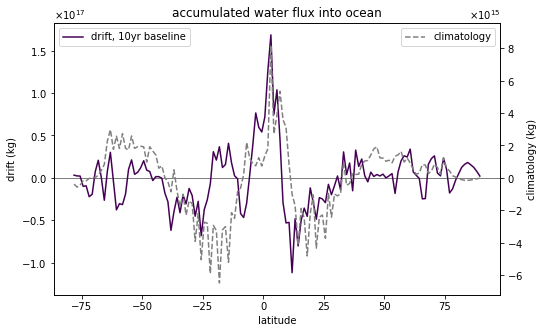

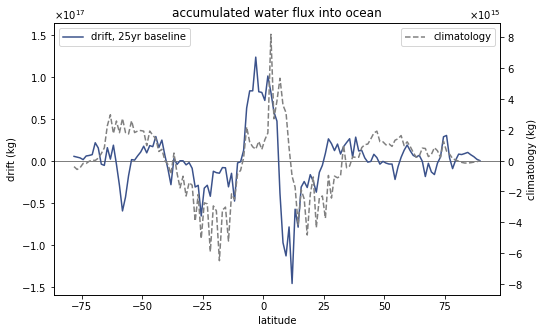

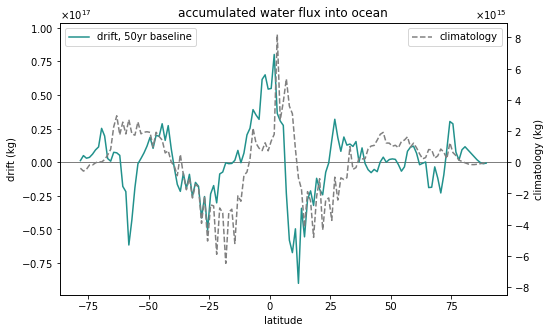

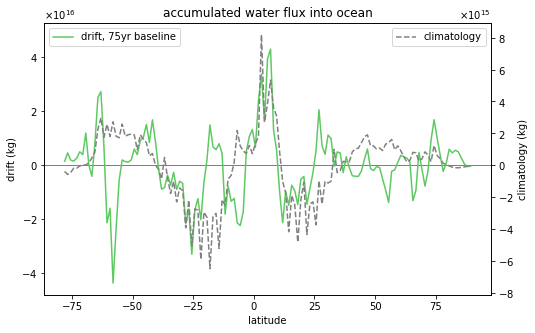

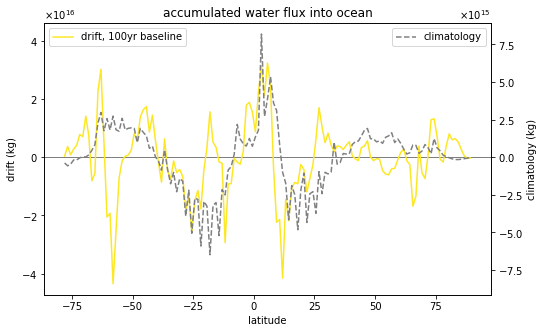

In [105]:
clim = cube.collapsed('time', iris.analysis.MEAN).data
lats = cube.coord('latitude').points
colors=iter(plt.cm.viridis(numpy.linspace(0, 1, 5)))
for baseline in [10, 25, 50, 75, 100]:
    drift = numpy.apply_along_axis(cumulative_anomaly, 0, cube.data, baseline)
    label = 'drift, %syr baseline' %(str(baseline))
    plot_drift(drift, clim, lats, next(colors), label)